This Notebook consists of two parts:

### 1. Report exploration
In this section we apply descriptive statistics to look at two features of the reports: the length of each report and the number of unique words in the report. We visualize these features using histograms and boxplots.

### 2. Term Salience Ranking
In this section, we consider two different populations: 
1. Positive notes, which are labeled as indicating for fluid collection
2. Negative notes, which are labeled as not indicating fluid collection.
Our aim in this project is to classify reports using only unstructured textual data. In this section we will explore whether there are certain terms that are strongly associated with the postiive class and could be used as features in a Supervised Machine Learning Algorithm.

In [245]:
import os, sys
import pickle
import numpy as np
import scipy

import sqlite3 as sqlite

import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
from sklearn.feature_selection import chi2, SelectKBest

from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict, Counter
stop = set(stopwords.words('english'))

DATADIR = '../stats_data'
DB = os.path.join(DATADIR, 'Reference Standard', 'radiology_reports.sqlite')
os.path.exists(DB)

True

In [219]:
conn = sqlite.connect(DB)
df = pd.read_sql("SELECT * FROM training_notes;", conn)

conn.close()

In [220]:
df.head()

,rowid,name,text,referenceXML,doc_class,subject,HADM_ID,CHARTDATE
0,1,No_10792_131562_05-29-20,\n CT ABDOMEN W/CONTRAST; CT PELVIS W/CONTRAS...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,32,131562,05-29-20
1,2,No_11050_126785_11-03-33,\n CT CHEST W/CONTRAST; CT ABDOMEN W/CONTRAST...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,34,126785,11-03-33
2,3,No_11879_166554_06-22-37,\n CTA CHEST W&W/O C &RECONS; CT 100CC NON IO...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,06-22-37
3,4,No_11879_166554_06-23-37,\n CT ABDOMEN W/O CONTRAST; CT PELVIS W/O CON...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,06-23-37
4,5,No_11879_166554_07-02-37,\n CT CHEST W/O CONTRAST \n ~ Reason: r/o ste...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,07-02-37


# 1. Exploring Report Lengths and Vocabulary

To get a general sense of what our data looks like, we'll examine two features of the report: First, the length of the reports, and second, the number of unique words in each report. 



In [326]:
# Define some helper functions
def display_statistics(arr, var_name):
    """
    Displays the mean and other descriptive statisistics 
    for an array of data.
    """
    print("Mean {}: {}".format(var_name, np.mean(arr)))
    print("Standard deviation {}: {}".format(var_name, np.std(arr)))
    print("Max {}: {}".format(var_name, np.max(arr)))
    print("Min {}: {}".format(var_name, np.min(arr)))
    
    
def plot_hist(arr, var_name):
    """
    Plots a histogram for an array of data.
    Adds a vertical solid line showing the mean
    and a dashed line showing the probablity distribution function (PDF)
    """
    num_total = len(arr)
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(arr, normed=1, alpha=0.9)
    
    # Add a line with the mean
    mean_value = np.mean(arr)
    ax.axvline(x=mean_value, c='orange')
    
    
    # Add a best fit line
    mu, sigma = scipy.stats.norm.fit(arr)

    y = mlab.normpdf(bins, mu, sigma)
    
    L = plt.plot(bins, y, 'r--', linewidth=2)
    
    
    ax.set_title("Distribution of {}".format(var_name))
    return fig, ax

def plot_boxplot(arr, var_name):
    fig, ax = plt.subplots()
    ax.boxplot(arr)
    ax.set_title("Distribution of {}".format(var_name))
    return fig, ax

def count_unique_words(text):
    """
    Counts the number of unique words in a text
    """
    return len(set(word_tokenize(text)))

### 1a. Report Lengths

In [276]:
# Average lengths of reports
df["text"] = df.text.apply(lambda x: x.lower())
reports = df.text

In [277]:
len(reports)

545

In [278]:
rpt_lengths = [len(x) for x in reports]

In [279]:
display_statistics(rpt_lengths, "Report Length")

Mean Report Length: 3443.256880733945
Standard deviation Report Length: 1516.280203363879
Max Report Length: 8806
Min Report Length: 393


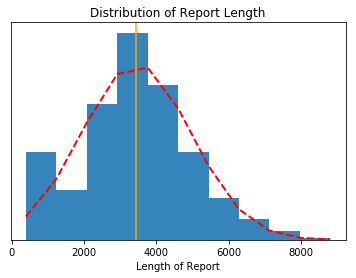

In [329]:
fig, ax =plot_hist(rpt_lengths, "Report Length")
# ax.set_ylabel("% Reports")
_ = ax.set_xlabel("Length of Report")
_ = ax.set_yticks([])

Text(0,0.5,'Length of Report')

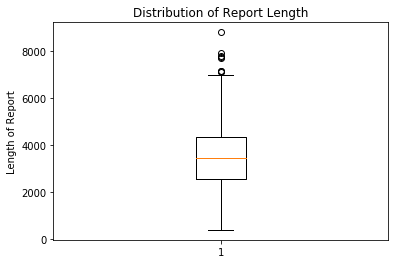

In [321]:
fig, ax = plot_boxplot(rpt_lengths, "Report Length")
ax.set_ylabel("Length of Report")

### 1b. Number of Unique Words in a Report

In [282]:
unique_word_counts = [count_unique_words(r) for r in reports]

In [283]:
display_statistics(unique_word_counts, "Unique Word Count")

Mean Unique Word Count: 236.81284403669724
Standard deviation Unique Word Count: 78.47597552189644
Max Unique Word Count: 477
Min Unique Word Count: 48


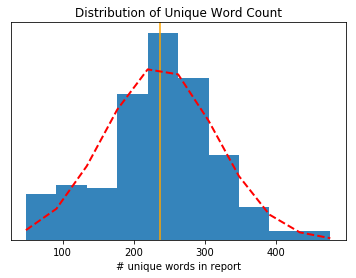

In [330]:
fig, ax = plot_hist(unique_word_counts, "Unique Word Count")
ax.set_xlabel("# unique words in report")
# _ = ax.set_ylabel("% Reports")
_ = ax.set_yticks([])

# 2. Ranking the salience of words

Our task is determining whether or not a fluid collection is present based on the text. To do this, we'll examine the vocabulary and determine which words are most indicitive of a positive document.

We'll use two methods for this:
#### a. Conditional Probablity
We want to compute the probability of the class "Fluid collection - positive" given a particular word. This is calculated as:


$$P(positive | word) = \frac{P(positive, word)}{P(word)}$$

We'll count the number of times that term appears in a positive or a negative document. We'll then use this to compute the conditional probablity of each term and analyze the terms that are most strongly associated with positive documents.

#### b. Chi2 Test
We'll use a Chi2 test of statistical independence to determine how strongly a particular word is associated with the positive class. For this we'll use the library `sklearn`.


### 2a. Conditional Probablity

In [285]:
# We'll consider unigrams and bigrams (one and two-word phrases)
ngram_reports = []
for text in df.text:
    tokens = []
    unigrams = [t for t in word_tokenize(text) if t not in stop]
    tokens += [(word, ) for word in unigrams]
    tokens += ngrams(unigrams, 2)

    ngram_reports.append(tokens)

In [286]:
# Create a dictionary that counts how many times a word occurs in either a positive or negative report
vocab = {}
for i, row in df.iterrows():
    grams = ngram_reports[i]
    c = 'negative' if row.doc_class == 0 else 'positive'
    for gram in grams:
        if gram not in vocab:
            vocab[gram] = {'positive': 0, 'negative': 0}
        vocab[gram][c] += 1

In [ ]:
# Limit to words that occur at least 10 times to cut out some noise
cond_probs = {}
for gram, d in vocab.items():
    total_count = d['negative'] + d['positive']
    if total_count < 10:
        continue
    cond_probs[' '.join(gram)] = {"cond_prob": d["positive"]/total_count, "total_count": total_count}
    
cond_probs 

In [ ]:
# What are the most salient terms?
list(sorted(cond_probs.items(), key=lambda x:x[1]["cond_prob"], reverse=True))[:10]

In [ ]:
# Some of these have low counts, which means that they probably just occurred in a small number of reports
# that happened to be positive. We'll set a threshold for probablity, take the n most frequent,
# and then sort by conditional probablity
n = 10
thresh = 0.9
cond_probs_to_plot = [(gram, d) for (gram, d) in cond_probs.items() if d["cond_prob"] >= thresh]
cond_probs_to_plot = list(sorted(cond_probs_to_plot, key=lambda x: x[1]["total_count"], reverse=True))[:n]
cond_probs_to_plot = sorted(cond_probs_to_plot, key=lambda x:x[1]["cond_prob"], reverse=True)
cond_probs_to_plot

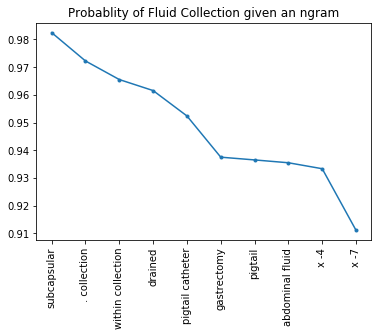

In [291]:
# Now plot this
n = 10
x = range(n)
words = [tup[0] for tup in cond_probs_to_plot[:n]]
# Plot the probablities
y = [tup[1]["cond_prob"] for tup in cond_probs_to_plot[:n]]
plt.plot(x, y, marker='.')
# Now add the text labels
# for i, (word, (prob, _)) in enumerate(cond_probs_to_plot[:n]):
#     plt.text(i, prob, word, rotation=-45)
plt.xticks(x, words, rotation=90)
_ = plt.title("Probablity of Fluid Collection given an ngram")

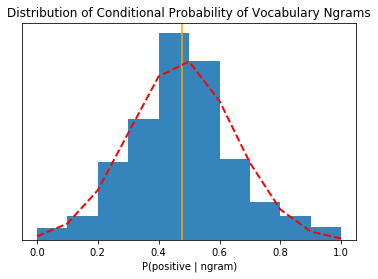

In [336]:
# Just for fun, let's plot a histogram of the conditional probs
probs = [d['cond_prob'] for (word, d) in cond_probs.items()]
fig, ax = plot_hist(probs, "Conditional Probability of Vocabulary Ngrams")
ax.set_xlabel("P(positive | ngram)")
_ = ax.set_yticks([])

 ### 2b. Chi-Squared
 
 - Now do the same thing using a Chi-Squared Test with sklearn. I preprocessed the data and transformed it into matrices. See `Report Classification.ipynb` to see the data transformation process.

In [292]:
DATADIR = '../stats_data'
INPATH = os.path.join(DATADIR, 'train_data.pkl')
VECTORIZER = os.path.join(DATADIR, 'vectorizer.pkl')

In [293]:
def load_data():
    with open(INPATH, 'rb') as f:
        X, y = pickle.load(f)
    with open(VECTORIZER, 'rb') as f:
        vectorizer = pickle.load(f)
    return X, y, vectorizer
X, y, vectorizer = load_data()

In [294]:
ch2 = SelectKBest(chi2, 100)
ch2.fit(X, y)

SelectKBest(k=100, score_func=<function chi2 at 0x109b4b048>)

In [295]:
def get_feature_scores(vectorizer, ch2):
    feature_names = vectorizer.get_feature_names()
    
    # (index, score)
    top_ranked = [(index, score) for (index, score)
                    in enumerate(ch2.scores_)]

    # Sort by score
    term_scores = [{'term': feature_names[idx], 'score': score} for (idx, score) in top_ranked]
    df = pd.DataFrame.from_dict(term_scores)
    df = df[['term', 'score']]
    return df
term_scores = get_feature_scores(vectorizer, ch2)
term_scores = term_scores.sort_values(by='score', ascending=False)
term_scores.head(n=10)

,term,score
117,collection,577.842366
259,fluid,284.480468
260,fluid collection,262.714097
288,hematoma,210.474145
115,cm,194.536101
213,drain,133.412460
214,drainage,106.216275
118,collections,101.425366
261,fluid collections,72.274042
99,catheter,67.579676


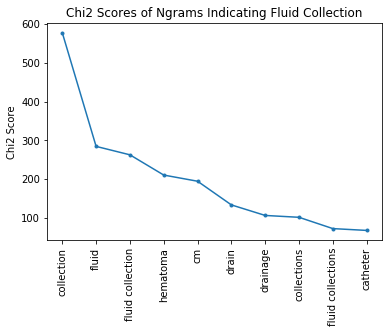

In [337]:
# Now plot the top 10 terms against their Chi2 scores
x = range(10)
terms = term_scores["term"].iloc[:10]
y = term_scores["score"].iloc[:10]

plt.plot(x, y, marker='.')
plt.ylabel("Chi2 Score")
plt.title("Chi2 Scores of Ngrams Indicating Fluid Collection")
_ = plt.xticks(x, terms,rotation=90)

Text(0,0.5,'Chi2 Score')

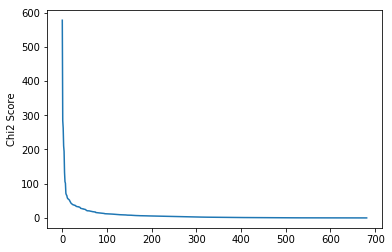

In [335]:
# Let's also plot the entire distribution
x = range(len(term_scores))
y = term_scores.score
plt.plot(x, y)
plt.ylabel("Chi2 Score")

# plt.set_yticks()

# Conclusion

Using both methods of salience ranking, we can see that we can find terms that are reasonably associated with fluid collections. These terms include:

- subcapsular
- collection
- fluid collection
- drain/drainage/drained
- pigtail catheter
- abdominal fluid
- cm

Some of these existed in the hand-crafted lexicons, while others did not but still appear to be useful terms. This indicates that probabilistic/statistical methods using text data may be effective for detecting fluid collections. Next, we'll train a number of ML classifiers to try and find the highest-performing algorithm.

# Up Next
[Report Classification](./3 - Report Classification.html)